# StackOverflow queries

StackOverflow is similar to a social network where users ask questions, respond to posts, leave comments, and rate other answers.
My task is to extract and analyse data from a database containing information dated in the year 2008 using SQL queries.

In [1]:
# libraries import
# database connection

## Query 1

**Task:** Select the 10 users who put in the most votes of the Close type.

In [5]:
query = '''
SELECT user_id, COUNT(id)
FROM stackoverflow.votes
WHERE vote_type_id IN (SELECT id
                        FROM stackoverflow.vote_types
                        WHERE name = 'Close')
GROUP BY user_id
ORDER BY COUNT(id) DESC, user_id DESC
LIMIT(10)
'''
query = pd.read_sql_query(query, con=engine) 
query

,user_id,count
0,20646,36
1,14728,36
2,27163,29
3,41158,24
4,24820,23
5,9345,23
6,3241,23
7,44330,20
8,38426,19
9,19074,19


## Query 2

**Task:** Calculate the average score that each user's post receives.

In [4]:
query = '''
SELECT title, user_id, score,
        ROUND(AVG(score) OVER (PARTITION BY user_id))
FROM stackoverflow.posts
WHERE title IS NOT NULL AND score != 0
'''
query = pd.read_sql_query(query, con=engine) 
query

,title,user_id,score,round
0,Diagnosing Deadlocks in SQL Server 2005,1,82,573.0
1,How do I calculate someone's age in C#?,1,1743,573.0
2,Why doesn't IE7 copy <pre><code> blocks to the...,1,37,573.0
3,Calculate relative time in C#,1,1348,573.0
4,Wrapping StopWatch timing with a delegate or l...,1,92,573.0
...,...,...,...,...
47349,Multi-lingual projects in Visual Studio,3742716,1,1.0
47350,Change datatype when importing Excel file into...,3930756,5,5.0
47351,How to host a Silverlight app in a Sharepoint ...,4020932,8,8.0
47352,Getting counts for a paged SQL search stored p...,5696608,2,2.0


## Query 3

**Task:** Display the titles of posts written by users who have received more than 1000 badges.

In [12]:
query = '''
SELECT title
FROM stackoverflow.posts
WHERE user_id IN (
            SELECT user_id
            FROM stackoverflow.badges
            GROUP BY user_id
            HAVING count(id) > 1000)
AND title IS NOT NULL
'''
query = pd.read_sql_query(query, con=engine) 
query

,title
0,What's the strangest corner case you've seen i...
1,What's the hardest or most misunderstood aspec...
2,What are the correct version numbers for C#?
3,Project management to go with GitHub


## Query 4

**Task:** 

Retrieve data about users from the United States, dividing them into three groups based on the number of profile views. Display the leaders of each group – users who have accumulated the maximum number of views within their respective groups.

In [19]:
query = '''
WITH a  AS (SELECT *, 
        MAX(views) OVER (PARTITION BY rank) AS max_value
FROM (SELECT id, views, 
        CASE
            WHEN views < 100 THEN 3
            WHEN views < 350 THEN 2
            ELSE 1           
        END AS rank
FROM stackoverflow.users
WHERE location LIKE '%%United States%%' AND views > 0) AS info)

SELECT id, rank, views
FROM a
WHERE max_value = views
ORDER BY views DESC, id
'''
query = pd.read_sql_query(query, con=engine) 
query.head()

,id,rank,views
0,16587,1,62813
1,9094,2,349
2,9585,2,349
3,15079,2,349
4,33437,2,349


## Query 5

**Task:** For each user who has written at least one post, find the interval between the registration time and the time of creating their first post.

In [21]:
query = '''
WITH a AS (SELECT DISTINCT user_id,
        FIRST_VALUE(creation_date) OVER (PARTITION BY user_id ORDER BY creation_date) AS first_post
FROM stackoverflow.posts)

SELECT a.user_id, 
         first_post - creation_date
FROM a
LEFT JOIN stackoverflow.users AS u ON a.user_id = u.id
'''
query = pd.read_sql_query(query, con=engine) 
query.head()

,user_id,?column?
0,41040,0 days 00:20:34
1,18721,0 days 00:17:46
2,279,2 days 00:07:41
3,36804,0 days 00:13:25
4,19068,1 days 01:54:55


## Query 6

**Task:**

Output the number of posts for the year 2008, categorized by months. Select posts from users who registered in September 2008 and made at least one post in December of the same year.

In [22]:
query = '''
SELECT CAST (DATE_TRUNC ('month' , creation_date) AS date),
        COUNT(id)
FROM stackoverflow.posts
WHERE user_id IN (SELECT u.id
FROM stackoverflow.users AS u
JOIN stackoverflow.posts AS p ON u.id = p.user_id
WHERE CAST (DATE_TRUNC ('month' , u.creation_date) AS date) = '2008-09-01' 
        AND CAST (DATE_TRUNC ('month' , p.creation_date) AS date) = '2008-12-01')
GROUP BY CAST (DATE_TRUNC ('month' , creation_date) AS date)
ORDER BY CAST (DATE_TRUNC ('month' , creation_date) AS date) DESC
'''
query = pd.read_sql_query(query, con=engine) 
query

,date_trunc,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


## Query 7

**Task:**

Calculate the average number of days users interacted with the platform during the period from December 1st to December 7th, 2008, inclusive. For each user, select the days on which they published at least one post.

In [23]:
query = '''
SELECT ROUND(AVG(days))
FROM ( SELECT user_id, COUNT(day) AS days
        FROM (SELECT DISTINCT user_id,
                creation_date::date AS day,
                  FIRST_VALUE(creation_date::date) OVER (PARTITION BY user_id,creation_date::date )
            FROM stackoverflow.posts
            WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07') t1
GROUP BY user_id) t2
'''
query = pd.read_sql_query(query, con=engine) 
query

,round
0,2.0


**Conclusion**

Overall, users interacted with the platform only two times during this period.

## Query 8

**Task:**


Retrieve the activity data for the user who posted the most in October 2008.

In [24]:
query = '''
SELECT EXTRACT (WEEK FROM creation_date), MAX(creation_date)
FROM stackoverflow.posts
WHERE user_id IN (SELECT user_id
                    FROM stackoverflow.posts
                    GROUP BY user_id
                    ORDER BY  COUNT(id) DESC
                    LIMIT 1)
AND CAST (DATE_TRUNC ('month', creation_date) AS date) = '2008-10-01'
GROUP BY EXTRACT (WEEK FROM creation_date)
'''
query = pd.read_sql_query(query, con=engine) 
query

,extract,max
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01


## Query 9

**Task:**

What percentage changed each month between September 1st and December 31st, 2008?

In [34]:
query = '''
SELECT *, 
        ROUND((((posts::numeric) /  LAG(posts) OVER (ORDER BY month) *100)-100),2)
FROM (SELECT EXTRACT(MONTH FROM creation_date) AS month, 
        COUNT(id) posts
FROM stackoverflow.posts
WHERE CAST (DATE_TRUNC ('day' , creation_date) AS date) BETWEEN '2008-09-01' AND '2008-12-31'
GROUP BY EXTRACT(MONTH FROM creation_date)) t1
'''
query = pd.read_sql_query(query, con=engine) 
query

,month,posts,round
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


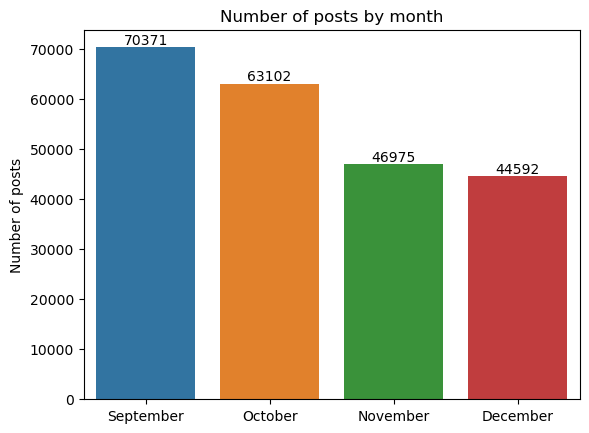

In [93]:
ax = sns.barplot(y=query['posts'], x=['September', 'October', 'November', 'December'])
for i, value in enumerate(query['posts']):
    ax.text(i, value, str(value), ha='center', va='bottom')
plt.title('Number of posts by month')
plt.ylabel('Number of posts');

## Query 10

**Task:**

Select 10 users by the number of badges received between November 15 and December 15, 2008 inclusive.

In [5]:
query = '''
WITH a AS (SELECT user_id, COUNT(id) AS badges
FROM stackoverflow.badges
WHERE creation_date:: date BETWEEN '2008-11-15' AND '2008-12-15'
GROUP BY user_id)

SELECT *,
        DENSE_RANK() OVER (ORDER BY badges DESC)
FROM a
LIMIT 10
'''
query = pd.read_sql_query(query, con=engine) 
query

,user_id,badges,dense_rank
0,22656,149,1
1,34509,45,2
2,1288,40,3
3,5190,31,4
4,13913,30,5
5,893,28,6
6,10661,28,6
7,33213,25,7
8,12950,23,8
9,25222,20,9
